In [1]:
import matplotlib.pyplot as plt
from cut_simulation.utils.misc import *
from hydra import compose, initialize
from roboninja.env.tc_env import get_cut_env
from roboninja.utils.misc import animate
import pickle


def forward(taichi_env, init_state, comp_actions, grad_enabled, render, **kwargs):
    taichi_env.set_state(init_state, grad_enabled=grad_enabled)

    actions_v = comp_actions[:-1]
    action_p = comp_actions[-1]
    horizon_action = len(actions_v)
    taichi_env.apply_agent_action_p(action_p)
    render_images = list()

    if render: render_images.append(taichi_env.render())
    for i in range(horizon_action):
        taichi_env.step(actions_v[i])
        if render: render_images.append(taichi_env.render())
    loss = taichi_env.get_loss()

    forward_output = {
        'loss': loss,
        'render_images': render_images
    }

    return forward_output


def backward(taichi_env, comp_actions, **kwargs):
    taichi_env.reset_grad()
    taichi_env.get_loss_grad()

    actions_v = comp_actions[:-1]
    horizon_action = len(actions_v)

    for i in range(horizon_action-1, -1, -1):
        taichi_env.step_grad(actions_v[i])
    grad = taichi_env.agent.get_grad(len(actions_v))
    grad[-1][1:] = 0

    backward_output = {
        'grad': grad,
    }

    return backward_output
    
# load config
initialize(version_base=None, config_path='roboninja/config/cut_env')
cfg = compose(config_name='cut_env')
bone_idx = 0
cfg.bone.name = f'bone_{bone_idx}'
taichi_env = get_cut_env(cfg)

knife = taichi_env.agent.effectors[0]

# set some constant
horizon_action = 60

# set init actions
init_action_p = np.asarray([-0.8, 0.215, 0.5])
init_action_v = np.asarray([[0., 0., 0.]] * horizon_action)
init_action_v[:int(horizon_action * 0.4), 1] = -0.3
init_actions = np.concatenate([init_action_v, init_action_p[None]], axis=0)

init_state = taichi_env.get_state()['state']
current_actions = init_actions


kwargs = {
    'taichi_env': taichi_env,
    'init_state': init_state,
    'comp_actions': current_actions,
    'grad_enabled': True,
    'render': True
}

[Taichi] version 1.3.0, llvm 15.0.4, commit 0f25b95e, linux, python 3.9.16
[I 03/30/23 21:38:31.169 1284399] [shell.py:_shell_pop_print@33] Graphical python shell detected, using wrapped sys.stdout
[Taichi] Starting on arch=cuda
===>    34908 particles of     meat     cube added.
[I 03/30/23 21:38:43.879 1284399] [vulkan_device_creator.cpp:pick_physical_device@399] Found Vulkan Device 0 (NVIDIA RTX A6000)
[I 03/30/23 21:38:43.879 1284399] [vulkan_device_creator.cpp:pick_physical_device@399] Found Vulkan Device 1 (NVIDIA RTX A6000)
[I 03/30/23 21:38:43.879 1284399] [vulkan_device_creator.cpp:pick_physical_device@399] Found Vulkan Device 2 (NVIDIA RTX A6000)
[I 03/30/23 21:38:43.879 1284399] [vulkan_device_creator.cpp:pick_physical_device@399] Found Vulkan Device 3 (NVIDIA RTX A6000)
[I 03/30/23 21:38:43.879 1284399] [vulkan_device_creator.cpp:create_logical_device@469] Vulkan Device "NVIDIA RTX A6000" supports Vulkan 0 version 1.3.194


render image

[W 03/30/23 21:38:47.731 1284399] [vulkan_device.cpp:buffer@620] Overriding last binding
[W 03/30/23 21:38:47.733 1284399] [vulkan_device.cpp:buffer@620] Overriding last binding
[W 03/30/23 21:38:47.734 1284399] [vulkan_device.cpp:buffer@620] Overriding last binding
[W 03/30/23 21:38:47.735 1284399] [vulkan_device.cpp:buffer@620] Overriding last binding


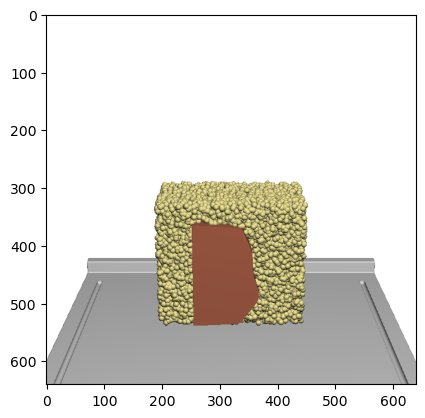

In [2]:
plt.imshow(taichi_env.render())

forward pass using the initial trajectory

In [3]:
forward_output = forward(**kwargs)
print(forward_output['loss'])
animate(forward_output['render_images'], 'videos/initial_trajectory.mp4')

{'loss': 0.18368882543461174, 'cut_loss': 0.015444821408410544, 'collision_loss': 0.0, 'rotation_loss': 0.0, 'move_loss': 0.01454695081967213, 'work_loss': 0.018523944179026055, 'work_curve': array([0., 0., 0., ..., 0., 0., 0.])}


compute action gradient w.r.t. loss

In [4]:
backward_output = backward(**kwargs)
gradient = backward_output['grad']

[W 03/30/23 21:39:15.072 1284399] [type_check.cpp:type_check_store@36] [$214066] Local store may lose precision: f32 <- f64

[W 03/30/23 21:39:15.131 1284399] [type_check.cpp:type_check_store@36] [$214283] Local store may lose precision: f32 <- f64

[W 03/30/23 21:39:15.203 1284399] [type_check.cpp:type_check_store@36] [$214643] Local store may lose precision: f32 <- f64

[W 03/30/23 21:39:16.215 1284399] [type_check.cpp:type_check_store@36] [$233907] Local store may lose precision: f32 <- f64

[W 03/30/23 21:39:34.811 1284399] [type_check.cpp:type_check_store@36] [$404353] Local store may lose precision: f32 <- f64

[W 03/30/23 21:39:34.811 1284399] [type_check.cpp:type_check_store@36] [$404358] Local store may lose precision: f32 <- f64

[W 03/30/23 21:39:34.811 1284399] [type_check.cpp:type_check_store@36] [$404363] Local store may lose precision: f32 <- f64

[W 03/30/23 21:39:58.881 1284399] [type_check.cpp:type_check_store@36] [$495254] Local store may lose precision: f32 <- f64



directly load the optimized trajectory

In [5]:
data = pickle.load(open(f'data/expert/expert_{bone_idx}/optimization.pkl', 'rb'))
kwargs['comp_actions'] = data[-1]['comp_actions']
forward_output = forward(**kwargs)
animate(forward_output['render_images'], 'videos/optimized_trajectory.mp4')